## Advantage Actor-Critic (A2C) on CartPole

Actor-critic is an algorithm that combines both policy gradient (the actor) and value function (the critic).

![A2C](imgs/Advantage_actor_critic.png)
Credit: Sergey Levine

A2C is a more sophisticated version of the actor-critic that use the advantage, n-step return and a policy is run in multiple (synchronous) environments. 
[A3C](https://arxiv.org/pdf/1602.01783.pdf) is an asynchronous A2C with the environments that are run in parallel. 

The Actor and Critic can share the same neural network or have two separate network design. In this example, I used a shared network.
<img src="imgs/nn_ac.png" alt="drawing" width="600"/>
Credit: Sergey Levine

In [1]:
import numpy as np
import gym
from tensorboardX import SummaryWriter

import datetime
from collections import namedtuple
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.clip_grad import clip_grad_norm_

In [11]:
class A2C_nn(nn.Module):
    '''
    Advantage actor-critic neural net
    '''

    def __init__(self, input_shape, n_actions):
        super(A2C_nn, self).__init__()

        self.lp = nn.Sequential(
            nn.Linear(input_shape[0], 64),
            nn.ReLU())

        self.policy = nn.Linear(64, n_actions)
        self.value = nn.Linear(64, 1)

    def forward(self, x):
        l = self.lp(x.float())
        # return the actor and the critic
        return self.policy(l), self.value(l)

The total loss contains:
- actor loss $\partial\theta_v\leftarrow\partial\theta_v + \dfrac{\partial(R-V_\theta(s))^2}{\partial\theta_v}$
- policy loss $\partial\theta_\pi\leftarrow\partial\theta_\pi + \alpha\triangledown_\theta log\pi_\theta(a|s)(R-V_\theta(s))$
- entropy loss $\beta\sum_i\pi_\theta(s)log\pi_\theta(s)$

In [12]:
def calculate_loss(memories, nn, writer):
    '''
    Calculate the loss of the memories
    '''

    #batch_mem = np.random.choice(len(memories), size=32)

    rewards = torch.tensor(np.array([m.reward for m in memories], dtype=np.float32))
    log_val = nn(torch.tensor(np.array([m.obs for m in memories], dtype=np.float32)))

    act_log_softmax = F.log_softmax(log_val[0], dim=1)[:,np.array([m.action for m in memories])]
    # Calculate the advantage
    adv = (rewards - log_val[1].detach())

    # actor loss (policy gradient)
    pg_loss = - torch.mean(act_log_softmax * adv)
    # critic loss (value loss)
    vl_loss = F.mse_loss(log_val[1].squeeze(-1), rewards)
    # entropy loss
    entropy_loss = ENTROPY_BETA * torch.mean(torch.sum(F.softmax(log_val[0], dim=1) * F.log_softmax(log_val[0], dim=1), dim=1))

    # total loss
    loss = pg_loss + vl_loss - entropy_loss

    # add scalar to the writer
    writer.add_scalar('loss', float(loss), n_iter)
    writer.add_scalar('pg_loss', float(pg_loss), n_iter)
    writer.add_scalar('vl_loss', float(vl_loss), n_iter)
    writer.add_scalar('entropy_loss', float(entropy_loss), n_iter)
    writer.add_scalar('actions', np.mean([m.action for m in memories]), n_iter)
    writer.add_scalar('adv', float(torch.mean(adv)), n_iter)
    writer.add_scalar('act_lgsoft', float(torch.mean(act_log_softmax)), n_iter)

    return loss

In [13]:
class Env:
    '''
    Environment class. Used to deal with multiple environments
    '''

    game_rew = 0
    last_game_rew = 0

    def __init__(self, env_name, n_steps, gamma):
        super(Env, self).__init__()

        # create the new environment
        self.env = gym.make(env_name)
        self.obs = self.env.reset()

        self.n_steps = n_steps
        self.action_n = self.env.action_space.n
        self.observation_n = self.env.observation_space.shape[0]
        self.gamma = gamma

    def step(self, agent):
        '''
        Execute the agent n_steps in the environment
        '''
        memories = []
        for s in range(self.n_steps):

            # get the agent policy
            pol_val = agent(torch.tensor(self.obs))
            s_act = F.softmax(pol_val[0])

            # get an action following the policy distribution
            action = int(np.random.choice(np.arange(self.action_n), p=s_act.detach().numpy(), size=1))

            # Perform a step in the environment
            new_obs, reward, done, _ = self.env.step(action)

            # update the memory
            memories.append(Memory(obs=self.obs, action=action, new_obs=new_obs, reward=reward, done=done))

            self.game_rew += reward
            self.obs = new_obs

            if done:
                # if done reset the env and the variables
                self.done = True
                # if the game is over, run_add take the 0 value
                self.run_add = 0
                self.obs = self.env.reset()

                self.last_game_rew = self.game_rew
                self.game_rew = 0
                break
            else:
                self.done = False

        if not self.done:
            # if the game isn't over, run_add take the value of the last state
            self.run_add = float(agent(torch.tensor(self.obs))[1])

        # compute the discount reward of the memories and return it
        return self.discounted_rewards(memories)


    def discounted_rewards(self, memories):
        '''
        Compute the discounted reward backward
        '''
        upd_memories = []

        for t in reversed(range(len(memories))):
            if memories[t].done: self.run_add = 0
            self.run_add = self.run_add * self.gamma + memories[t].reward

            # Update the memories with the discounted reward
            upd_memories.append(Memory(obs=memories[t].obs, action=memories[t].action, new_obs=memories[t].new_obs, reward=self.run_add, done=memories[t].done))

        return upd_memories[::-1]


In [2]:
Memory = namedtuple('Memory', ['obs', 'action', 'new_obs', 'reward', 'done'], rename=False)

# Hyperparameters
GAMMA = 0.95
LEARNING_RATE = 0.003
ENTROPY_BETA = 0.2
ENV_NAME = 'LunarLander-v2'

MAX_ITER = 100000
# Number of the env
N_ENVS = 40

# Max normalized gradient
CLIP_GRAD = 0.1

device = 'cpu'

now = datetime.datetime.now()
date_time = "{}_{}.{}.{}".format(now.day, now.hour, now.minute, now.second)

In [3]:
# create N_ENVS environments
envs = [Env(ENV_NAME, 1, GAMMA) for _ in range(N_ENVS)]

writer = SummaryWriter(log_dir='content/runs/A2C'+ENV_NAME+'_'+date_time)

# initialize the actor-critic NN
agent_nn = A2C_nn(gym.make(ENV_NAME).observation_space.shape, gym.make(ENV_NAME).action_space.n).to(device)

# Adam optimizer
optimizer = optim.Adam(agent_nn.parameters(), lr=LEARNING_RATE, eps=1e-3)

experience = []
n_iter = 0

while n_iter < MAX_ITER:
    n_iter += 1

    # list containing all the memories
    memories = [mem for env in envs for mem in env.step(agent_nn)]

    # calculate the loss
    losses = calculate_loss(memories, agent_nn, writer)

    # optimizer step
    optimizer.zero_grad()
    losses.backward()
    # clip the gradient
    clip_grad_norm_(agent_nn.parameters(), CLIP_GRAD)
    optimizer.step()


    writer.add_scalar('rew', np.mean([env.last_game_rew for env in envs]), n_iter)
    print(n_iter, np.round(float(losses),2), 'rew:', np.round(np.mean([env.last_game_rew for env in envs]),2))

writer.close()

NameError: name 'Env' is not defined

### ATTENTION! the model is not working, look at the graph below. Why this strange behavior? I tried to tune the hyperparameters but the results are the same.
![Reward plot](imgs/reward_plot_a2c.png)

#### Why is the loss decreasing so fast? 
![Reward plot](imgs/loss_plot_a2c.png)

#### In some cases, the model start preferring always the same action..
![Reward plot](imgs/actions_plot_a2c.png)

Some idea:
 - Use two different neural networks and optimizer

In [39]:
import argparse
import gym
import os
import sys
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

import matplotlib.pyplot as plt

#import ipdb

# if gpu is to be used
use_cuda = torch.cuda.is_available()
#use_cuda = False
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

class Actor(nn.Module):
    def __init__(self, state_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, 8)
        #self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class A2C(object):
    def __init__(self, env, args):
        super(A2C, self).__init__()
        self.env = env
        self.actor = Actor(env.observation_space.shape[0], env.action_space.n)
        self.critic = Critic(env.observation_space.shape[0])
        if use_cuda:
            self.actor.cuda()
            self.critic.cuda()
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=args.lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=args.lr_critic)
        self.N_steps = args.N_steps
        self.num_episodes = args.num_episodes
        self.test_episodes = args.test_episodes
        #self.num_steps = args.num_steps
        self.gamma = args.gamma
        self.expt_name = args.expt_name
        self.save_path = args.save_path
        self.test_freq = args.test_freq
        self.save_freq = args.save_freq
        self.train_rewards = []
        self.test_rewards = []
        self.train_steps = []
        self.test_steps = []
        self.losses_actor = []
        self.losses_critic = []

    def select_action(self, state):
        state = Variable(Tensor(state))
        log_probs = self.actor(state)
        value = self.critic(state)
        action = Categorical(log_probs.exp()).sample()
        return action.data.cpu().item(), log_probs[action], value

    def play_episode(self, e):
        state = self.env.reset()
        steps = 0
        rewards = []
        log_probs = []
        values = []
        # for i in range(self.num_steps):
        while True:
            action, log_prob, value = self.select_action(state)
            if (np.random.random() <= max(0.01, 0*0.5*(len(self.train_rewards)**0.8))):
                action = env.action_space.sample() 
#             print(action, log_prob)
            state, reward, is_terminal, _ = self.env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value)
            steps +=1
            if is_terminal or steps >= 300:
#                 if is_terminal and reward >= 100:
#                     rewards.append(reward)
#                 if steps>=900:
#                     rewards[-1]=-10000
                break
#         print(log_probs)
        a = torch.stack(log_probs)
        b = torch.stack(values)
        return steps, rewards, a,b

    def optimize(self, rewards, log_probs, values):
        T = len(rewards)
        N = T #self.N_steps
        R = np.zeros(T, dtype=np.float32)
        loss_actor = 0
        loss_critic = 0
        for t in reversed(range(T)):
            V_end = 0 if (t+N >= T) else values[t+N].data
#             V_end = values[-1].data
            R[t] = (self.gamma**N * V_end) + sum([self.gamma**k * rewards[t+k]*1e-2 for k in range(min(N, T-t))])
        R = Variable(Tensor(R), requires_grad=False)
        # compute losses using the advantage function;
        # Note: `values` is detached while computing loss for actor
        loss_actor = ((R - values.detach()) * -log_probs).mean()
        loss_critic = ((R - values)**2).mean()
        # loss = loss_actor + loss_critic

        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        loss_actor.backward()
        loss_critic.backward()
        # nn.utils.clip_grad_norm(self.actor.parameters(), grad_norm_limit)
        # nn.utils.clip_grad_norm(self.critic.parameters(), grad_norm_limit)
        self.optimizer_actor.step()
        self.optimizer_critic.step()
        # self.losses.append(loss.detach().cpu().item())
        # ipdb.set_trace()
        self.losses_actor.append(loss_actor.data.cpu().item())
        self.losses_critic.append(loss_critic.data.cpu().item())

    def train(self, num_episodes):
        print("Going to be training for a total of {} episodes".format(num_episodes))
        state = Variable(torch.Tensor(self.env.reset()))
        for e in range(num_episodes):
            steps, rewards, log_probs, values = self.play_episode(e)
            self.train_rewards.append(sum(rewards))
            self.train_steps.append(steps)
            self.optimize(rewards, log_probs,values)

            if (e+1) % 100 == 0:
                print("Episode: {}, reward: {}, steps: {}".format(e+1, sum(rewards), steps))

            # Freeze the current policy and test over 100 episodes
            if (e+1) % self.test_freq == 0:
                print("-"*10 + " testing now " + "-"*10)
                self.test(self.test_episodes, e)

            # Save the current policy model
            if (e+1) % (self.save_freq) == 0:
                torch.save(self.actor.state_dict(),  os.path.join(self.save_path, "train_actor_ep_{}.pkl".format(e+1)))
                torch.save(self.critic.state_dict(), os.path.join(self.save_path, "train_critic_ep_{}.pkl".format(e+1)))

        # plot once when done training
        # self.plot_rewards(save=True)

    def test(self, num_episodes, e_train):
        state = Variable(torch.Tensor(self.env.reset()))
        testing_rewards = []
        testing_steps = []
        for e in range(num_episodes):
            steps, rewards, log_probs,values = self.play_episode(e)
            self.test_rewards.append(sum(rewards))
            self.test_steps.append(steps)
            testing_rewards.append(sum(rewards))
            testing_steps.append(steps)
        print("Mean reward achieved : {} ".format(np.mean(testing_rewards)))
        print("-"*50)
        if np.mean(testing_rewards) >= 200:
            print("-"*10 + " Solved! " + "-"*10)
            print("Mean reward achieved : {} in {} steps".format(np.mean(testing_rewards), np.mean(testing_steps)))
            print("-"*50)
            # if (e_train+1) % 5000 == 0: self.plot_rewards(save=True)
            # else: self.plot_rewards(save=False)
#         if (e_train+1) % 5000 == 0: self.plot_rewards(save=True)
        #else: self.plot_rewards(save=False)

#     def plot_rewards(self, save=False):
#         train_rewards = [self.train_rewards[i:i+self.test_freq] for i in range(0,len(self.train_rewards),self.test_freq)]
#         test_rewards = [self.test_rewards[i:i+self.test_episodes] for i in range(0,len(self.test_rewards),self.test_episodes)]
#         train_losses_actor = [self.losses_actor[i:i+self.test_freq] for i in range(0,len(self.losses_actor),self.test_freq)]
#         train_losses_critic = [self.losses_critic[i:i+self.test_freq] for i in range(0,len(self.losses_critic),self.test_freq)]
#         train_losses = [self.losses_critic[i:i+self.test_freq]+self.losses_actor[i:i+self.test_freq] for i in range(0,len(self.losses_critic),self.test_freq)]

#         # rewards
#         train_rewards_mean = [np.mean(i) for i in train_rewards]
#         test_rewards_mean = [np.mean(i) for i in test_rewards]
#         train_rewards_std = [np.std(i) for i in train_rewards]
#         test_rewards_std = [np.std(i) for i in test_rewards]
#         train_nepisodes = [self.test_freq * (i+1) for i in range(len(train_rewards_mean))]

#         # steps
#         train_steps = [self.train_steps[i:i+self.test_freq] for i in range(0,len(self.train_steps),self.test_freq)]
#         test_steps = [self.test_steps[i:i+self.test_episodes] for i in range(0,len(self.test_steps),self.test_episodes)]
#         train_steps_mean = [np.mean(i) for i in train_steps]
#         test_steps_mean = [np.mean(i) for i in test_steps]
#         train_steps_std = [np.mean(i) for i in train_steps]
#         test_steps_std = [np.mean(i) for i in test_steps]

#         # loss
#         train_losses_actor_mean = [np.mean(i) for i in train_losses_actor]
#         train_losses_actor_std = [np.std(i) for i in train_losses_actor]
#         train_losses_critic_mean = [np.mean(i) for i in train_losses_critic]
#         train_losses_critic_std = [np.std(i) for i in train_losses_critic]
#         train_losses_mean = [np.mean(i) for i in train_losses]
#         train_losses_std = [np.std(i) for i in train_losses]


#         # training : reward over time
#         plt.figure(1)
#         plt.clf()
#         plt.title("Training : Avg. Reward over {} episodes".format(self.test_episodes))
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg Reward")
#         plt.errorbar(train_nepisodes, train_rewards_mean, yerr=train_rewards_std, color="indigo", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "train_rewards_{}.png".format(len(self.train_rewards)))
#         else:
#             plt.show()
#             # pause so that the plots are updated
#             plt.pause(0.001)

#         # testing : reward over time
#         plt.figure(2)
#         plt.clf()
#         plt.title("Testing : Avg. Reward over {} episodes".format(self.test_episodes))
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg Reward")
#         try:
#             plt.errorbar(train_nepisodes, test_rewards_mean, yerr=test_rewards_std, color="indigo", uplims=True, lolims=True)
#         except:
#             ipdb.set_trace()
#         if save :
#             plt.savefig(self.expt_name + "test_rewards_{}.png".format(len(self.test_rewards)))
#         else:
#             plt.show()

#         # training : avg number of steps per episode
#         plt.figure(3)
#         plt.clf()
#         plt.title("Training : Avg. number of steps taken per episode")
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg number of steps")
#         plt.errorbar(train_nepisodes, train_steps_mean, yerr=train_steps_std, color="navy", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "train_steps_{}.png".format(len(self.train_steps)))
#         else:
#             plt.show()
#             # pause so that the plots are updated
#             plt.pause(0.001)

#         # testing : avg number of steps per episode
#         plt.figure(4)
#         plt.clf()
#         plt.title("Testing : Avg. number of steps taken per episode")
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg number of steps")
#         plt.errorbar(train_nepisodes, test_steps_mean, yerr=test_steps_std, color="navy", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "test_steps_{}.png".format(len(self.test_steps)))
#         else:
#             plt.show()

#         # training : avg actor loss over time
#         plt.figure(5)
#         plt.clf()
#         plt.title("Avg. Actor Training Loss over {} episodes".format(train_nepisodes[-1]))
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg. Loss")
#         # plt.plot(train_losses_mean, color="crimson")
#         plt.errorbar(train_nepisodes, train_losses_mean, yerr=train_losses_std, color="tomato", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "train_loss_actor_{}.png".format(len(self.test_rewards)))
#         else:
#             plt.show()

#         # training : avg critic loss over time
#         plt.figure(5)
#         plt.clf()
#         plt.title("Avg. Critic Training Loss over {} episodes".format(train_nepisodes[-1]))
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg. Loss")
#         # plt.plot(train_losses_mean, color="crimson")
#         plt.errorbar(train_nepisodes, train_losses_mean, yerr=train_losses_std, color="tomato", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "train_loss_critic_{}.png".format(len(self.test_rewards)))
#         else:
#             plt.show()

#         # training : combined avg loss over time
#         plt.figure(5)
#         plt.clf()
#         plt.title("Avg. AC Combined Training Loss over {} episodes".format(train_nepisodes[-1]))
#         plt.xlabel("Number of training episodes")
#         plt.ylabel("Avg. Loss")
#         # plt.plot(train_losses_mean, color="crimson")
#         plt.errorbar(train_nepisodes, train_losses_mean, yerr=train_losses_std, color="crimson", uplims=True, lolims=True)
#         if save :
#             plt.savefig(self.expt_name + "train_loss_{}.png".format(len(self.test_rewards)))
#         else:
#             plt.show()

class Parameters:
    def __init__(self):
        self.gamma=0.99
        self.lr_actor=5e-4
        self.lr_critic=5e-4
        self.num_episodes=50000
        self.test_episodes=100
        self.num_steps=50
        self.seed=123
        self.save_freq=1e4
        self.test_freq=500
        self.save_path="models/a2c/"
        self.expt_name="plots/a2c/"
        self.N_steps=100


use_cuda :  False


In [40]:
            
args = Parameters()
    
args.gamma=1#0.999
args.lr_actor=1e-3
args.lr_critic=1e-3
args.num_episodes=6000
args.test_episodes=100
args.num_steps= 50 #50 # 100
args.seed=42
args.save_freq=1e3
args.test_freq=500
args.save_path="models/a2c/"
args.expt_name="plots/a2c/"
args.N_steps=100 # 100 # 150


if not os.path.exists(args.save_path):
    os.mkdir(args.save_path)
if not os.path.exists(args.expt_name):
    os.mkdir(args.expt_name)

    # create the environment
env = gym.make("LunarLander-v2")
env.seed(42)
torch.manual_seed(42)
    # plt.ion()

    # A2C agent
agent = A2C(env, args)


In [43]:
agent.train(args.num_episodes)
# agent.test()

env.close()

Going to be training for a total of 6000 episodes
Episode: 100, reward: -122.30156991409949, steps: 96
Episode: 200, reward: -127.46004434545941, steps: 67
Episode: 300, reward: -215.76605939604448, steps: 142
Episode: 400, reward: -291.8439174120204, steps: 91
Episode: 500, reward: -81.08061617731016, steps: 92
---------- testing now ----------
Mean reward achieved : -156.13038348683725 
--------------------------------------------------
Episode: 600, reward: -134.63791855610393, steps: 106
Episode: 700, reward: -166.15928971803794, steps: 124
Episode: 800, reward: -250.27291483450063, steps: 130
Episode: 900, reward: -194.36722354220686, steps: 90
Episode: 1000, reward: -65.35684506145581, steps: 70
---------- testing now ----------
Mean reward achieved : -95.91424853112586 
--------------------------------------------------
Episode: 1100, reward: -112.91760616298335, steps: 71
Episode: 1200, reward: -72.0961660305822, steps: 89
Episode: 1300, reward: -168.7194481369853, steps: 131
E

In [7]:
def select_action(actor,critic, state):
    state = Variable(Tensor(state))
    log_probs = actor(state)
    value = critic(state)
    action = Categorical(log_probs.exp()).sample()
    return action.data.cpu().item()

In [13]:
actor = agent.actor
actor.load_state_dict(torch.load('models/a2c/models_3/train_actor_ep_6000.pkl'))
critic = agent.critic
critic.load_state_dict(torch.load('models/a2c/models_3/train_critic_ep_6000.pkl'))


<All keys matched successfully>

In [38]:

tsteps=0
treward=0
frames = []
env.close()
for nexps in range(3):   # Let's do 10 trials
    done= False  
    observation = env.reset()
    t = 0
    while not done:# and t < 1000:
        env.render()
#         action = select_action(actor, critic, observation)
        action, _, _ = agent.select_action(observation)
        observation, reward, done, info = env.step(action) # take action from learned policy
        treward = treward + reward
        tsteps = tsteps + 1
        t +=1
env.close()
print(treward)

-361.80152118072124


In [22]:
def save_arrays(matrix, PATH):
    np.savetxt(PATH, np.array(matrix) , fmt='%f')

def load_arrays(PATH):
    return np.loadtxt(PATH)

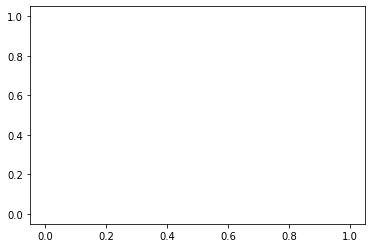

In [42]:
plt.plot(agent.train_rewards)
plt.show()

In [24]:
len(agent.train_rewards)
save_arrays(agent.train_rewards, 'results/a2c/rewards_3.dat')